In [1]:
import pandas as pd
import numpy as np 
import talib as ta # fxテクニカル指標
import lightgbm as lgb
import matplotlib.pyplot as plt # グラフ描画用
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score # 正答率見るやつ
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import log_loss # モデル評価用(logloss) 
from sklearn.metrics import roc_auc_score # モデル評価用(auc)

In [139]:
# CSVファイルの読み込み。2017-2019の２年分
df = pd.read_csv('usdjpy_2013-20190626.csv')
# 最後の5行を確認
df.tail()

,Date,Open,High,Low,Close
1624,2019/6/19,108.472,108.616,107.906,108.084
1625,2019/6/20,108.079,108.141,107.213,107.304
1626,2019/6/21,107.305,107.735,107.050,107.377
1627,2019/6/24,107.295,107.538,107.249,107.308
1628,2019/6/25,107.311,107.410,106.781,107.143


In [140]:
# 翌日終値 - 当日終値で差分を計算
#shift(-1)でcloseを上に1つずらす
df['close+1'] = df.Close.shift(-1)
df['diff'] = df['close+1'] - df['Close']
# 最終日はclose+1がNaNになるので削る
df = df[:-1]
# close+1を追加して翌日と比較
# df.tail()
# 上昇と下降のデータ割合を確認
m = len(df['Close'])
# df['diff']>0で全行に対してtrueかfalseで返してくれる。df[(df['diff'] > 0)]でdff>0に絞って全てのカラムを出力
#上昇した日の割合
print(len(df[(df['diff'] > 0)]) / m * 100)
# 下降した日の割合
print(len(df[(df['diff'] < 0)]) / m * 100)

50.73710073710074
48.95577395577396


In [141]:
df.rename(columns={"diff" : "target"}, inplace=True)

# 不要なカラムを削除
del df['close+1']
del df['Date']
# カラムの並び替え
df = df[['target', 'Open', 'High', 'Low', 'Close']]
# 最初の5行を出力
# df.head()
df.loc[df['target'] > 0, "target"] = 1
df.loc[df['target'] < 0, "target"] = 0
# 最初の5行を出力
# df.head()
#移動平均の計算、5日、25日、50日、75日
#ついでにstdも計算する。（=ボリンジャーバンドと同等の情報を持ってる）
#75日分のデータ確保
for i in range(1, 75):
    df['close-'+str(i)] = df.Close.shift(+i)
#移動平均の値とstdを計算する, skipnaの設定で一つでもNanがあるやつはNanを返すようにする
nclose = 5    
df['MA5'] = df.iloc[:, np.arange(nclose, nclose+5)].mean(axis='columns', skipna=False)
df['MA13'] = df.iloc[:, np.arange(nclose, nclose+13)].mean(axis='columns', skipna=False)
df['MA25'] = df.iloc[:, np.arange(nclose, nclose+25)].mean(axis='columns', skipna=False)
df['MA50'] = df.iloc[:, np.arange(nclose, nclose+50)].mean(axis='columns', skipna=False)
df['MA75'] = df.iloc[:, np.arange(nclose, nclose+75)].mean(axis='columns', skipna=False)

# df['STD3'] = df.iloc[:, np.arange(nclose, nclose+3)].std(axis='columns', skipna=False) # STDの要素が強いので足してみた
df['STD5'] = df.iloc[:, np.arange(nclose, nclose+5)].std(axis='columns', skipna=False)
df['STD25'] = df.iloc[:, np.arange(nclose, nclose+25)].std(axis='columns', skipna=False)
df['STD50'] = df.iloc[:, np.arange(nclose, nclose+50)].std(axis='columns', skipna=False)
df['STD75'] = df.iloc[:, np.arange(nclose, nclose+75)].std(axis='columns', skipna=False)
# 計算終わったら余分な列は削除
for i in range(1, 75):
    del df['close-'+str(i)]
# それぞれの平均線の前日からの変化（移動平均線が上向か、下向きかわかる）
# shift(-1)でcloseを上に1つずらす
df['diff_MA5'] = df['MA5'] - df.MA5.shift(1)
#df['diff_MA13'] = df['MA13'] - df.MA13.shift(1)
df['diff_MA25'] = df['MA25'] - df.MA25.shift(1) 
df['diff_MA50'] = df['MA50'] - df.MA50.shift(1) 
df['diff_MA75'] = df['MA75'] - df.MA75.shift(1) 
#
#del df['MA5']
#del df['MA25']
#del df['MA50']
#del df['MA75']

# テクニカル指標の導入
close = df['Close']
#RSI
df['RSI9'] = ta.RSI(close,timeperiod=9)
df['RSI14'] = ta.RSI(close, timeperiod=14)
#MACD
#df['MACD'], _ , _= ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
#ボリンジャーバンド 
upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
df['BBANDS+2σ'] = upper / close
df['BBANDS-2σ'] = lower / close

# https://non-dimension.com/indicator/
def RCI(close, timeperiod = 9):
    rci = []
    for j in range(len(close)):
        if j < timeperiod:
            rci.append(np.nan)    
        else:
            data = pd.DataFrame()
            data['close'] = list(close[j-timeperiod:j])
            data = data.reset_index()
            data = data.rename(columns = {'index':'original_index'}) #最初のindex情報を残しておきます
            data = data.sort_values('close',ascending=False).reset_index(drop = True) #closeの値が高い順に並べ替えます
            data = data.reset_index() #indexをresetします
            data['index'] = [i+1 for i in data['index']] #resetしたindexは0〜8なので、1〜9の順位に変換するために1を足します
            data = data.rename(columns = {'index':'price_rank'}) #closeの高い順に並べたindexをprice rankという列名にします
            data = data.set_index('original_index') #元のindexに戻します
            data = data.sort_index() #元のindexに戻します
            data['date_rank'] = np.arange(timeperiod,0,-1) #元のindexに日付順位をつけます
            data['delta'] = [(data.loc[ii,'price_rank']-data.loc[ii,'date_rank'])**2 for ii in range(len(data))] #dの値を計算します
            d = data['delta'].sum() #dの値を計算します
            value = (1-(6*d)/(timeperiod**3-timeperiod))*100 #rciを計算します
            rci.append(value)
    return rci

#df['RCI'] = RCI(close)

# 3日前までのopen, close, high, lowも素性に加えたい
#NaNを含む行を削除
#for i in range(1, 4):
    #df['close-'+str(i)] = df.Close.shift(+i)
    #df['open-'+str(i)] = df.Open.shift(+i)
    #df['high-'+str(i)] = df.High.shift(+i)
    #df['low-'+str(i)] = df.Low.shift(+i)

# NaNを含む行を削除
df = df.dropna()

#何日分使うか決める
nday =500
df = df[-nday:]
df.head()
df

,target,Open,High,Low,Close,MA5,MA13,MA25,MA50,MA75,...,STD50,STD75,diff_MA5,diff_MA25,diff_MA50,diff_MA75,RSI9,RSI14,BBANDS+2σ,BBANDS-2σ
1128,0.0,112.631,112.661,111.687,112.071,113.1244,113.173692,112.24448,111.87966,111.481725,...,1.347341,1.506477,-0.2870,0.10904,-0.01282,0.021867,39.178723,46.359606,1.028233,0.982714
1129,0.0,112.071,112.228,111.558,111.880,112.7446,113.169538,112.32420,111.84130,111.497501,...,1.312924,1.498729,-0.3798,0.07972,-0.03836,0.015776,36.739884,44.548247,1.029397,0.985407
1130,0.0,111.889,112.419,111.493,111.854,112.4830,113.124308,112.41244,111.79316,111.507760,...,1.264660,1.494819,-0.2616,0.08824,-0.04814,0.010259,36.392954,44.294536,1.028787,0.986997
1131,1.0,111.847,112.076,111.016,111.099,112.1962,113.005538,112.45108,111.75374,111.512429,...,1.230286,1.492813,-0.2868,0.03864,-0.03942,0.004669,27.813093,37.598237,1.036134,0.993202
1132,1.0,111.144,111.299,110.626,111.177,111.9070,112.835615,112.46176,111.71028,111.511747,...,1.213829,1.490252,-0.2892,0.01068,-0.04346,-0.000683,29.738318,38.630451,1.036436,0.990868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0.0,108.568,108.677,108.064,108.468,108.5070,108.458769,109.09376,110.17308,110.465027,...,1.344599,1.244350,0.0256,-0.02612,-0.06226,-0.042179,40.521602,38.664151,1.020567,0.985636
1624,0.0,108.472,108.616,107.906,108.084,108.4878,108.371769,109.04648,110.11256,110.419104,...,1.352011,1.254443,-0.0192,-0.04728,-0.06052,-0.045923,32.066091,33.865926,1.020716,0.990536
1625,1.0,108.079,108.141,107.213,107.304,108.4072,108.349923,108.98624,110.05148,110.369656,...,1.373553,1.275359,-0.0806,-0.06024,-0.06108,-0.049448,21.712695,26.635276,1.028064,0.995654
1626,0.0,107.305,107.735,107.050,107.377,108.1936,108.292000,108.88396,109.97912,110.309381,...,1.421229,1.319464,-0.2136,-0.10228,-0.07236,-0.060275,24.286587,28.180773,1.027332,0.993221


In [142]:
# データの確認
# トレーニングデータ,テストデータの分割
print(df.shape) # データサイズの確認(データ数,特徴量数(変数の個数))
display(df) # df.head()に同じ(文中に入れるときはdisplay()を使う)

# 説明変数,目的変数
X = df.drop('target',axis=1) # 説明変数(target以外の特徴量)
y = df['target'].values # 目的変数(target)

# トレーニングデータ,テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.80, random_state=2)

(500, 22)


,target,Open,High,Low,Close,MA5,MA13,MA25,MA50,MA75,...,STD50,STD75,diff_MA5,diff_MA25,diff_MA50,diff_MA75,RSI9,RSI14,BBANDS+2σ,BBANDS-2σ
1128,0.0,112.631,112.661,111.687,112.071,113.1244,113.173692,112.24448,111.87966,111.481725,...,1.347341,1.506477,-0.2870,0.10904,-0.01282,0.021867,39.178723,46.359606,1.028233,0.982714
1129,0.0,112.071,112.228,111.558,111.880,112.7446,113.169538,112.32420,111.84130,111.497501,...,1.312924,1.498729,-0.3798,0.07972,-0.03836,0.015776,36.739884,44.548247,1.029397,0.985407
1130,0.0,111.889,112.419,111.493,111.854,112.4830,113.124308,112.41244,111.79316,111.507760,...,1.264660,1.494819,-0.2616,0.08824,-0.04814,0.010259,36.392954,44.294536,1.028787,0.986997
1131,1.0,111.847,112.076,111.016,111.099,112.1962,113.005538,112.45108,111.75374,111.512429,...,1.230286,1.492813,-0.2868,0.03864,-0.03942,0.004669,27.813093,37.598237,1.036134,0.993202
1132,1.0,111.144,111.299,110.626,111.177,111.9070,112.835615,112.46176,111.71028,111.511747,...,1.213829,1.490252,-0.2892,0.01068,-0.04346,-0.000683,29.738318,38.630451,1.036436,0.990868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0.0,108.568,108.677,108.064,108.468,108.5070,108.458769,109.09376,110.17308,110.465027,...,1.344599,1.244350,0.0256,-0.02612,-0.06226,-0.042179,40.521602,38.664151,1.020567,0.985636
1624,0.0,108.472,108.616,107.906,108.084,108.4878,108.371769,109.04648,110.11256,110.419104,...,1.352011,1.254443,-0.0192,-0.04728,-0.06052,-0.045923,32.066091,33.865926,1.020716,0.990536
1625,1.0,108.079,108.141,107.213,107.304,108.4072,108.349923,108.98624,110.05148,110.369656,...,1.373553,1.275359,-0.0806,-0.06024,-0.06108,-0.049448,21.712695,26.635276,1.028064,0.995654
1626,0.0,107.305,107.735,107.050,107.377,108.1936,108.292000,108.88396,109.97912,110.309381,...,1.421229,1.319464,-0.2136,-0.10228,-0.07236,-0.060275,24.286587,28.180773,1.027332,0.993221


In [143]:
# LightGBMによる決定木モデルの訓練
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# モデルの学習(scikit-learn API で書いたとき)
# model = lgb.LGBMRegressor() # モデルのインスタンスの作成
# model.fit(X_train, y_train) # モデルの学習
# LightGBM parameters
lgb_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 回帰→'regression'  多分類→'multiclass'  二値分類→'binary'他には 'binary_logloss','auc'など
        'metric': {'binary_error'},
        'learning_rate': 0.01,
        'num_leaves': 20, # １つの木の最大葉数
        'min_data_in_leaf': 1,
        'num_iteration': 1000, # 1000回学習
        'verbose': 0
}
model = lgb.train(lgb_params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  num_boost_round=1000, # ブースト上限
                  early_stopping_rounds=50 # 50回ごとに検証精度改善→改善しないなら学習終了（過学習防止）
                 )

# テストデータの予測
y_pred_prob = model.predict(X_test)
# テストデータの予測 (予測クラス(0 or 1)を返す)
y_pred = np.where(y_pred_prob < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	valid_0's binary_error: 0.51
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_error: 0.53
[3]	valid_0's binary_error: 0.54
[4]	valid_0's binary_error: 0.57
[5]	valid_0's binary_error: 0.57
[6]	valid_0's binary_error: 0.59
[7]	valid_0's binary_error: 0.6
[8]	valid_0's binary_error: 0.59
[9]	valid_0's binary_error: 0.59
[10]	valid_0's binary_error: 0.58
[11]	valid_0's binary_error: 0.58
[12]	valid_0's binary_error: 0.56
[13]	valid_0's binary_error: 0.57
[14]	valid_0's binary_error: 0.57
[15]	valid_0's binary_error: 0.57
[16]	valid_0's binary_error: 0.58
[17]	valid_0's binary_error: 0.59
[18]	valid_0's binary_error: 0.59
[19]	valid_0's binary_error: 0.57
[20]	valid_0's binary_error: 0.58
[21]	valid_0's binary_error: 0.58
[22]	valid_0's binary_error: 0.58
[23]	valid_0's binary_error: 0.57
[2

In [136]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test,'target_pred':y_pred})
display(df_pred)

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'target':y_test, 'target0_prob':1-y_pred_prob, 'target1_prob':y_pred_prob})
display(df_pred_prob)

,target,target_pred
0,0.0,0
1,0.0,1
2,0.0,0
3,0.0,1
4,1.0,1
...,...,...
95,1.0,1
96,0.0,1
97,0.0,1
98,1.0,0


,target,target0_prob,target1_prob
0,0.0,0.578612,0.421388
1,0.0,0.467571,0.532429
2,0.0,0.533704,0.466296
3,0.0,0.450423,0.549577
4,1.0,0.472049,0.527951
...,...,...,...
95,1.0,0.490489,0.509511
96,0.0,0.424035,0.575965
97,0.0,0.484472,0.515528
98,1.0,0.526947,0.473053


In [137]:
# モデル評価
# acc : 正答率
print()
acc = accuracy_score(y_test,y_pred)
print('正答率（Acc） :', acc)

# logloss 
logloss =  log_loss(y_test,y_pred_prob) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
print('logloss :', logloss)

# AUC 
auc = roc_auc_score(y_test,y_pred_prob) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
print('AUC :', auc)


正答率（Acc） : 0.54
logloss : 0.6982371775767767
AUC : 0.49759132878362106


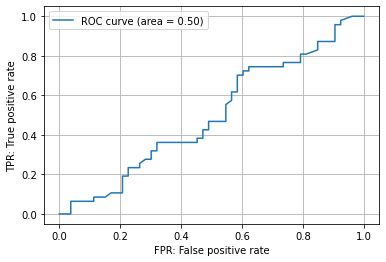

In [138]:
# ROC曲線の描画
# cf : https://tips-memo.com/python-roc
from sklearn import metrics
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob)
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

[22  0 33 16 17  2 14 37 22 19 27 45 24 56 82 17 57 23]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

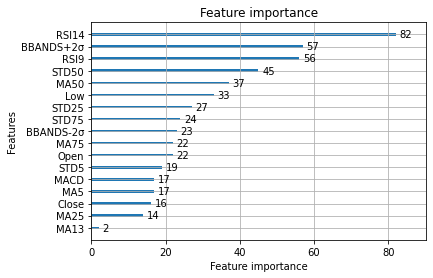

In [130]:
# 特徴量の重要度出力
print(model.feature_importance())

# 特徴量の重要度をプロット
lgb.plot_importance(model)